# fMRI Learning Stage Classification using Vision Transformers

This notebook implements a Vision Transformer model to classify different stages of learning from fMRI data.

### Abstract

This research project presents an innovative approach to understanding the temporal dynamics of human learning through the analysis of functional Magnetic Resonance Imaging (fMRI) data using Vision Transformers (ViT). By leveraging advanced deep learning architectures, we aim to classify different stages of learning (early, middle, and late) based on neural activation patterns during a classification learning task.

The study utilizes the "[Classification Learning](https://openfmri.org/dataset/ds000002/)" dataset from OpenfMRI, which captures brain activity during a weather prediction task under both probabilistic and deterministic conditions. This dataset provides a unique opportunity to examine how the brain's activity patterns evolve as subjects progress through different learning phases, potentially revealing distinct neural signatures associated with each stage of skill acquisition.

### Introduction

Understanding how the human brain adapts and reorganizes during learning remains a fundamental challenge in cognitive neuroscience. Traditional approaches to analyzing learning-related neural changes often rely on univariate analyses or conventional machine learning methods. However, these approaches may miss complex spatial and temporal patterns that characterize different learning stages.

Our methodology introduces several key innovations:

1. **Vision Transformer Architecture**: By adapting ViT models to process 3D fMRI data, we leverage the transformer's ability to capture long-range dependencies and complex spatial relationships within neural activation patterns. This approach treats brain volumes as sequences of patches, allowing the model to learn hierarchical representations of neural activity patterns.

2. **Temporal Learning Classification**: The project aims to automatically identify and classify distinct phases of learning (early, middle, and late) based on whole-brain activation patterns. This classification could reveal how neural representations evolve throughout the learning process.

3. **Multi-condition Analysis**: By incorporating both probabilistic and deterministic learning conditions, we can investigate how different types of learning rules affect neural activation patterns and their temporal evolution.

### Expected Outcomes and Impact

This research has the potential to:

- Identify neural markers of learning progression
- Reveal differences in brain activation patterns between probabilistic and deterministic learning
- Provide insights into individual differences in learning trajectories
- Demonstrate the effectiveness of transformer-based architectures in neuroimaging analysis

By successfully classifying learning stages from fMRI data, this work could contribute to our understanding of skill acquisition and learning optimization, with potential applications in educational neuroscience and cognitive rehabilitation.

## Setup and Dependencies

#### Install required packages

In [ ]:
!pip install einops nibabel seaborn tqdm monai matplotlib nilearn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 83.7 MB/s eta 0:00:00


#### Import libraries

In [ ]:
import os
import random
import urllib.request
import zipfile
from pathlib import Path
import math
import re
from collections import defaultdict
from google.colab import drive

Data processing

In [ ]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting, image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import traceback

Deep learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast
from torch.amp import GradScaler
from torch.nn import init
from einops import rearrange, repeat
from timm.models.layers import DropPath
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR, CosineAnnealingWarmRestarts
from collections import defaultdict

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import display, HTML
from tqdm.notebook import tqdm

#### Set random seeds

In [ ]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seeds()

## Data Loading and Visualization Functions

In [ ]:
class fMRIVisualizer:
    """Handles visualization of fMRI data at different preprocessing stages"""

    @staticmethod
    def plot_slice_viewer(img_data, title="fMRI Slice Viewer"):
        """Interactive slice viewer using plotly"""
        if len(img_data.shape) == 4:
            img_data = img_data.mean(axis=-1)  # Average across time

        fig = go.Figure(data=go.Volume(
            x=img_data.shape[0],
            y=img_data.shape[1],
            z=img_data.shape[2],
            value=img_data,
            isomin=img_data.min(),
            isomax=img_data.max(),
            opacity=0.1,
            surface_count=25,
        ))

        fig.update_layout(title=title, height=600)
        fig.show()

    @staticmethod
    def plot_preprocessing_steps(original, normalized, final):
        """Shows preprocessing stages side by side"""
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot middle slices of each volume
        axes[0].imshow(original[original.shape[0]//2, :, :], cmap='gray')
        axes[0].set_title('Original')

        axes[1].imshow(normalized[normalized.shape[0]//2, :, :], cmap='gray')
        axes[1].set_title('Normalized')

        axes[2].imshow(final[final.shape[0]//2, :, :], cmap='gray')
        axes[2].set_title('Final Processed')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_augmentation_example(original, augmented):
        """Shows original and augmented data side by side"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Plot three orthogonal views for original
        axes[0,0].imshow(original[original.shape[0]//2, :, :].squeeze(), cmap='gray')
        axes[0,1].imshow(original[:, original.shape[1]//2, :].squeeze(), cmap='gray')
        axes[0,2].imshow(original[:, :, original.shape[2]//2].squeeze(), cmap='gray')
        axes[0,0].set_title('Original - Axial')
        axes[0,1].set_title('Original - Coronal')
        axes[0,2].set_title('Original - Sagittal')

        # Plot three orthogonal views for augmented
        axes[1,0].imshow(augmented[augmented.shape[0]//2, :, :].squeeze(), cmap='gray')
        axes[1,1].imshow(augmented[:, augmented.shape[1]//2, :].squeeze(), cmap='gray')
        axes[1,2].imshow(augmented[:, :, augmented.shape[2]//2].squeeze(), cmap='gray')
        axes[1,0].set_title('Augmented - Axial')
        axes[1,1].set_title('Augmented - Coronal')
        axes[1,2].set_title('Augmented - Sagittal')

        plt.tight_layout()
        plt.show()

#### Download and extract dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/learnedSpectrum'
zip_path = os.path.join(base_path, "ds000002_R2.0.5_raw.zip")
extract_path = os.path.join(base_path, "fmri_data")

In [ ]:
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    url = "https://s3.amazonaws.com/openneuro/ds000002/ds000002_R2.0.5/compressed/ds000002_R2.0.5_raw.zip"
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete!")

In [ ]:
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")

## Enhanced Dataset and Preprocessing

In [ ]:
class AdvancedFMRIPreprocessor:
    """
    Advanced preprocessing pipeline for fMRI data with visualization capabilities.
    Implements state-of-the-art preprocessing techniques for small datasets.
    """
    def __init__(self, target_shape=(64, 64, 64), temporal_window=8):
        self.target_shape = target_shape
        self.temporal_window = temporal_window
        self.visualizer = fMRIVisualizer()

    def preprocess_volume(self, img_data, visualize=False):
        """
        Comprehensive preprocessing pipeline with optional visualization
        """
        # Store original for visualization
        original = img_data.copy()

        # Brain extraction and background removal
        mask = self._create_brain_mask(img_data)
        img_data = self._apply_brain_mask(img_data, mask)

        # Temporal processing for 4D data
        if len(img_data.shape) == 4:
            img_data = self._process_temporal(img_data)

        # Spatial normalization
        normalized = self._normalize_volume(img_data)

        # Spatial standardization
        final = self._standardize_space(normalized)

        if visualize:
            self.visualizer.plot_preprocessing_steps(
                original[..., 0] if len(original.shape) == 4 else original,
                normalized[..., 0] if len(normalized.shape) == 4 else normalized,
                final[..., 0] if len(final.shape) == 4 else final
            )

            # Show 3D visualization
            self.visualizer.plot_slice_viewer(final, "Preprocessed fMRI Volume")

        return final.astype(np.float32)

    def _create_brain_mask(self, img_data):
        """Create binary mask of brain tissue"""
        if len(img_data.shape) == 4:
            # Use temporal mean for 4D data
            mean_data = np.mean(img_data, axis=-1)
        else:
            mean_data = img_data

        # Otsu's thresholding for brain extraction
        thresh = np.percentile(mean_data[mean_data > 0], 10)
        return mean_data > thresh

    def _apply_brain_mask(self, img_data, mask):
        """Apply brain mask to data"""
        if len(img_data.shape) == 4:
            for t in range(img_data.shape[-1]):
                img_data[..., t] *= mask
        else:
            img_data *= mask
        return img_data

    def _process_temporal(self, img_data):
        """Process temporal dimension of 4D data"""
        # Select evenly spaced timepoints
        total_timepoints = img_data.shape[-1]
        indices = np.linspace(0, total_timepoints-1, self.temporal_window, dtype=int)
        return img_data[..., indices]

    def _normalize_volume(self, volume):
        """Robust volume normalization"""
        if volume.ndim == 4:
            normalized = np.zeros_like(volume)
            for t in range(volume.shape[-1]):
                normalized[..., t] = self._normalize_single_volume(volume[..., t])
            return normalized
        return self._normalize_single_volume(volume)

    def _normalize_single_volume(self, vol):
        """Normalize single 3D volume"""
        mask = vol != 0
        if mask.any():
            # Robust normalization using percentiles
            p1, p99 = np.percentile(vol[mask], (1, 99))
            vol = np.clip((vol - p1) / (p99 - p1 + 1e-8), 0, 1)

            # Z-score normalization within mask
            mean = np.mean(vol[mask])
            std = np.std(vol[mask])
            vol[mask] = (vol[mask] - mean) / (std + 1e-8)
        return vol

    def _standardize_space(self, volume):
        """Standardize spatial dimensions"""
        return self._pad_or_crop(volume, self.target_shape)

    def _pad_or_crop(self, volume, target_shape):
        """Center-aligned padding or cropping"""
        if volume.ndim == 4:
            result = np.zeros((*target_shape, volume.shape[-1]), dtype=np.float32)
        else:
            result = np.zeros(target_shape, dtype=np.float32)

        for i in range(3):
            if volume.shape[i] > target_shape[i]:
                # Center crop
                start = (volume.shape[i] - target_shape[i]) // 2
                end = start + target_shape[i]
                slices = [slice(None)] * volume.ndim
                slices[i] = slice(start, end)
                volume = volume[tuple(slices)]
            else:
                # Center pad
                pad_before = (target_shape[i] - volume.shape[i]) // 2
                pad_after = target_shape[i] - volume.shape[i] - pad_before
                pad_width = [(0, 0)] * volume.ndim
                pad_width[i] = (pad_before, pad_after)
                volume = np.pad(volume, pad_width, mode='constant')

        return volume

In [ ]:
class EnhancedAugmentation:
    """
    Advanced augmentation pipeline specifically designed for small fMRI datasets.
    Implements conservative augmentations to prevent artifact introduction.
    """
    def __init__(self, p=0.5, intensity_range=(0.9, 1.1), noise_range=(0.01, 0.03)):
        self.p = p
        self.intensity_range = intensity_range
        self.noise_range = noise_range
        self.visualizer = fMRIVisualizer()

    def __call__(self, x, visualize=False):
        """Apply augmentation with optional visualization"""
        original = x.clone()

        if torch.rand(1) < self.p:
            # Conservative intensity scaling
            if torch.rand(1) < 0.5:
                scale = self.intensity_range[0] + torch.rand(1) * (
                    self.intensity_range[1] - self.intensity_range[0]
                )
                x = x * scale

            # Subtle Gaussian noise
            if torch.rand(1) < 0.3:
                noise_level = self.noise_range[0] + torch.rand(1) * (
                    self.noise_range[1] - self.noise_range[0]
                )
                x = x + torch.randn_like(x) * noise_level

            # Random flips (anatomically plausible)
            if torch.rand(1) < 0.5:
                x = torch.flip(x, dims=[torch.randint(1, 3, (1,)).item()])

            # Small random rotations
            if torch.rand(1) < 0.3:
                angle = torch.randint(-10, 11, (1,)).item()
                x = self._rotate(x, angle)

        if visualize:
            self.visualizer.plot_augmentation_example(
                original.cpu().numpy(),
                x.cpu().numpy()
            )

        return x

    def _rotate(self, x, angle):
        """Apply small rotation to volume"""
        # Implementation for small rotation
        return x  # Placeholder - implement actual rotation

In [ ]:
class ImprovedFMRIDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None):
        self.root_dir = Path(root_dir)
        self.phase = phase
        self.transform = transform
        self.preprocessor = AdvancedFMRIPreprocessor()
        self.temporal_window = 8
        self.target_shape = (64, 64, 64)
        self.samples = []

        # Load and preprocess samples
        self._load_samples()

        # Print dataset statistics
        self._print_statistics()

    def _find_dataset_root(self):
        """Recursively find the directory containing subject folders"""
        print(f"\nSearching for dataset root starting from: {self.root_dir}")

        # First try direct path
        if 'ds002_R2.0.5' in os.listdir(self.root_dir):
            ds_path = self.root_dir / 'ds002_R2.0.5'
            sub_dirs = sorted([d for d in os.listdir(ds_path) if d.startswith('sub-')])
            if sub_dirs:
                print(f"Found subject directories in: {ds_path}")
                return ds_path, sub_dirs

        # If not found, search recursively
        for root, dirs, _ in os.walk(self.root_dir):
            if 'ds002_R2.0.5' in dirs:
                ds_path = Path(root) / 'ds002_R2.0.5'
                sub_dirs = sorted([d for d in os.listdir(ds_path) if d.startswith('sub-')])
                if sub_dirs:
                    print(f"Found subject directories in: {ds_path}")
                    return ds_path, sub_dirs

        raise ValueError(f"Could not find dataset in {self.root_dir}")

    def _process_subject(self, dataset_root, subject):
        """Process individual subject data with 2-run handling"""
        subject_samples = []
        func_path = dataset_root / subject / 'func'

        if not func_path.exists():
            return []

        # Group files by task and ensure proper ordering
        task_files = defaultdict(list)
        for file in func_path.glob('*_bold.nii.gz'):
            if 'task-' not in file.name or 'mixedeventrelatedprobe' in file.name:
                continue

            # Extract task and run info
            try:
                task = file.name.split('task-')[1].split('_')[0]
                run_match = re.search(r'run-(\d+)', file.name)
                if not run_match:
                    print(f"Warning: No run number found in {file.name}")
                    continue

                run_num = int(run_match.group(1))
                task_files[task].append((run_num, file))
                print(f"Found {task} run {run_num}: {file.name}")
            except Exception as e:
                print(f"Error processing {file.name}: {str(e)}")
                continue

        # Process each task separately
        for task, files in task_files.items():
            if len(files) < 2:  # Need at least 2 runs
                print(f"Skipping task {task} - insufficient runs ({len(files)})")
                continue

            # Sort by run number
            sorted_files = sorted(files, key=lambda x: x[0])
            total_runs = len(sorted_files)

            # For 2 runs: first run is early stage, second run is late stage
            print(f"\nTask {task}:")

            # Early stage (first run)
            file_path = sorted_files[0][1]
            print(f"Early stage run: {sorted_files[0][0]}")
            subject_samples.append((file_path, 0))

            # Late stage (last run)
            file_path = sorted_files[-1][1]
            print(f"Late stage run: {sorted_files[-1][0]}")
            subject_samples.append((file_path, 1))

            print(f"Added 2 samples from task {task}")

        print(f"\nTotal samples for {subject}: {len(subject_samples)}")
        return subject_samples

    def _validate_samples(self, all_samples):
        """Validate sample integrity"""
        print("\nValidating samples...")
        valid_samples = []

        for file_path, label in all_samples:
            try:
                # Try loading the file
                img = nib.load(file_path)
                img_data = img.get_fdata()
                print(f"Validated: {os.path.basename(str(file_path))} - Shape: {img_data.shape}")
                valid_samples.append((file_path, label))
            except Exception as e:
                print(f"Warning: Could not load {file_path}: {str(e)}")
                continue

        return valid_samples

    def _analyze_dataset(self, samples):
        """Print dataset analysis"""
        print("\nDataset Analysis:")
        tasks = defaultdict(int)
        subjects = defaultdict(int)
        stages = defaultdict(int)

        for file_path, label in samples:
            # Extract information
            subject = str(file_path).split('sub-')[1].split('/')[0]
            task = str(file_path).split('task-')[1].split('_')[0]

            tasks[task] += 1
            subjects[subject] += 1
            stages['early' if label == 0 else 'late'] += 1

        print("\nTask distribution:")
        for task, count in tasks.items():
            print(f"  {task}: {count} samples")

        print("\nSubject distribution:")
        for subject, count in subjects.items():
            print(f"  {subject}: {count} samples")

        print("\nStage distribution:")
        for stage, count in stages.items():
            print(f"  {stage}: {count} samples")

    def _split_samples(self, all_samples):
        """Split samples while maintaining class balance in each set"""
        # Sort for reproducibility
        all_samples.sort(key=lambda x: str(x[0]))

        # Split by class
        early_samples = [s for s in all_samples if s[1] == 0]
        late_samples = [s for s in all_samples if s[1] == 1]

        # Calculate split sizes
        total_early = len(early_samples)
        total_late = len(late_samples)

        print(f"\nTotal samples before split:")
        print(f"Early stage: {total_early}")
        print(f"Late stage: {total_late}")

        # Calculate balanced split indices
        train_early = int(total_early * 0.7)
        train_late = int(total_late * 0.7)
        val_early = int(total_early * 0.15)
        val_late = int(total_late * 0.15)

        if self.phase == 'train':
            early_subset = early_samples[:train_early]
            late_subset = late_samples[:train_late]
        elif self.phase == 'val':
            early_subset = early_samples[train_early:train_early+val_early]
            late_subset = late_samples[train_late:train_late+val_late]
        else:  # test
            early_subset = early_samples[train_early+val_early:]
            late_subset = late_samples[train_late+val_late:]

        # Combine and shuffle
        balanced_subset = early_subset + late_subset
        random.shuffle(balanced_subset)

        print(f"\n{self.phase.capitalize()} set split:")
        print(f"Early stage: {len(early_subset)}")
        print(f"Late stage: {len(late_subset)}")

        return balanced_subset

    def _load_samples(self):
        """Load all samples with improved error handling"""
        try:
            print(f"\nLoading {self.phase} samples...")

            # Find dataset root
            dataset_root, subjects = self._find_dataset_root()

            # Collect all samples with improved stage labeling
            all_samples = []
            for subject in tqdm(subjects, desc="Processing subjects"):
                try:
                    subject_samples = self._process_subject(dataset_root, subject)
                    all_samples.extend(subject_samples)
                except Exception as e:
                    print(f"Error processing subject {subject}: {str(e)}")
                    continue

            if not all_samples:
                raise ValueError("No valid samples found in the dataset")

            # Split samples for phase
            self.samples = self._split_samples(all_samples)

            if not self.samples:
                raise ValueError(f"No samples found for {self.phase} phase")

        except Exception as e:
            print(f"Error loading dataset: {str(e)}")
            raise

    def _load_and_preprocess_sample(self, file_path):
        """Load and preprocess a single sample"""
        try:
            # Load nifti file
            img = nib.load(file_path)
            img_data = img.get_fdata()

            # Preprocess
            processed = self.preprocessor.preprocess_volume(img_data)

            # Convert to tensor
            tensor = torch.from_numpy(processed).float()

            # Handle dimensionality
            if len(tensor.shape) == 4:
                tensor = tensor.permute(3, 0, 1, 2)
                tensor = tensor.mean(dim=0, keepdim=True)
            else:
                tensor = tensor.unsqueeze(0)

            return tensor

        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")
            return None

    def _print_statistics(self):
        """Print detailed dataset statistics"""
        early_count = sum(1 for s in self.samples if s[1] == 0)
        late_count = sum(1 for s in self.samples if s[1] == 1)

        print(f"\nDataset Statistics ({self.phase} set):")
        print(f"Total samples: {len(self.samples)}")
        print(f"Early stage samples: {early_count}")
        print(f"Late stage samples: {late_count}")
        print(f"Class balance: {early_count/len(self.samples):.2%} early, "
              f"{late_count/len(self.samples):.2%} late")

    def __getitem__(self, idx):
        try:
            file_path, stage = self.samples[idx]

            # Load and preprocess
            tensor = self._load_and_preprocess_sample(file_path)

            if tensor is None:
                print(f"WARNING: Failed to load sample {file_path}")
                return torch.zeros((1, *self.target_shape)), torch.tensor(-1)

            # Apply transform if in training phase
            if self.transform is not None and self.phase == 'train':
                tensor = self.transform(tensor)

            return tensor, torch.tensor(stage, dtype=torch.long)

        except Exception as e:
            print(f"Error retrieving sample {idx}: {str(e)}")
            return torch.zeros((1, *self.target_shape)), torch.tensor(-1)

    def __len__(self):
        return len(self.samples)

    def visualize_sample(self, idx):
        """
        Visualize a sample with preprocessing steps showing orthogonal views.
        Handles 4D fMRI data properly by visualizing middle time point slices.
        """
        file_path, stage = self.samples[idx]

        try:
            # Load original data
            print(f"\nLoading sample: {file_path}")
            print(f"Learning stage: {'Early' if stage == 0 else 'Late'}")

            img = nib.load(file_path)
            original_data = img.get_fdata()
            print(f"Original shape: {original_data.shape}")

            # Handle 4D data by taking middle time point
            if len(original_data.shape) == 4:
                mid_time = original_data.shape[-1] // 2
                original_data = original_data[..., mid_time]
                print(f"Taking middle timepoint: {mid_time}")

            # Create figure
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            plt.suptitle(f"Sample {idx} (Stage: {'Early' if stage == 0 else 'Late'})")

            # Get middle slices for original data
            mid_x = original_data.shape[0] // 2
            mid_y = original_data.shape[1] // 2
            mid_z = original_data.shape[2] // 2

            # Plot original data views
            axes[0, 0].imshow(original_data[mid_x, :, :], cmap='gray')
            axes[0, 0].set_title('Original - Sagittal')

            axes[0, 1].imshow(original_data[:, mid_y, :], cmap='gray')
            axes[0, 1].set_title('Original - Coronal')

            axes[0, 2].imshow(original_data[:, :, mid_z], cmap='gray')
            axes[0, 2].set_title('Original - Axial')

            # Get preprocessed data
            processed = self._load_and_preprocess_sample(file_path)
            print("\nPreprocessed shape:", processed.shape)
            processed = processed.squeeze().numpy()

            # Plot preprocessed data views
            mid_x = processed.shape[0] // 2
            mid_y = processed.shape[1] // 2
            mid_z = processed.shape[2] // 2

            axes[1, 0].imshow(processed[mid_x, :, :], cmap='gray')
            axes[1, 0].set_title('Processed - Sagittal')

            axes[1, 1].imshow(processed[:, mid_y, :], cmap='gray')
            axes[1, 1].set_title('Processed - Coronal')

            axes[1, 2].imshow(processed[:, :, mid_z], cmap='gray')
            axes[1, 2].set_title('Processed - Axial')

            # Turn off axes
            for ax_row in axes:
                for ax in ax_row:
                    ax.axis('off')

            plt.tight_layout()
            plt.show()

            # Print additional sample information
            print("\nSample Information:")
            info = self.get_sample_info(idx)
            for key, value in info.items():
                print(f"{key}: {value}")

        except Exception as e:
            print(f"\nError visualizing sample {idx}:")
            print(str(e))
            traceback.print_exc()

    def get_sample_info(self, idx):
        """Get detailed information about a sample"""
        file_path, stage = self.samples[idx]
        img = nib.load(file_path)

        info = {
            'File': str(file_path).split('/')[-1],
            'Stage': 'Early' if stage == 0 else 'Late',
            'Subject': str(file_path).split('sub-')[1].split('/')[0],
            'Task': str(file_path).split('task-')[1].split('_')[0],
            'Dimensions': img.shape,
            'Data Type': img.get_data_dtype(),
            'Voxel Size': img.header.get_zooms()[:3],
            'Units': img.header.get_xyzt_units()
        }

        # Try to extract run number
        try:
            run_num = re.findall(r'run-(\d+)', str(file_path))[0]
            info['Run Number'] = run_num
        except:
            info['Run Number'] = 'Unknown'

        return info

## Advanced Vision Transformer Components

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.spatial_gate = nn.Sequential(
            nn.Conv3d(channels, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.channel_gate = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(channels, channels // 16, kernel_size=1),
            nn.BatchNorm3d(channels // 16),
            nn.ReLU(inplace=True),
            nn.Conv3d(channels // 16, channels, kernel_size=1),
            nn.BatchNorm3d(channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        spatial_attention = self.spatial_gate(x)
        channel_attention = self.channel_gate(x)
        return x * spatial_attention * channel_attention

In [ ]:
class AdaptiveLayerNorm(nn.Module):
    """
    Adaptive Layer Normalization that learns scaling factors based on input statistics
    """
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.scale_adaptor = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.GELU(),
            nn.Linear(dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Compute standard layer norm
        normed = self.norm(x)

        # Compute adaptive scaling factor
        scale = self.scale_adaptor(x.mean(dim=1))
        scale = scale.unsqueeze(1)

        return normed * scale

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4., qkv_bias=False,
                 drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim=dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop
        )
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [ ]:
class ResBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels)
        )

        self.attention = AttentionModule(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm3d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv_block(x)
        out = self.attention(out)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ImprovedVisionTransformer3D(nn.Module):
    def __init__(self, img_size=64, in_channels=1, num_classes=2):
        super().__init__()

        # Feature extraction pathway
        self.features = nn.Sequential(
            # Initial convolution with smaller kernel
            nn.Conv3d(in_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            # First block
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            # Second block
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            # Adaptive pooling to handle variable input sizes
            nn.AdaptiveAvgPool3d((4, 4, 4))
        )

        # Calculate feature dimensions
        with torch.no_grad():
            sample_input = torch.zeros(1, in_channels, img_size, img_size, img_size)
            feature_size = self.features(sample_input).numel() // 1

        # Multiple dense layers with skip connections
        self.classifier = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(512, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv3d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, (nn.BatchNorm3d, nn.LayerNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x, return_features=False):
        features = self.features(x)
        features_flat = features.view(features.size(0), -1)
        logits = self.classifier(features_flat)

        if return_features:
            return logits, [features_flat]
        return logits

## Training Loop and Loss Functions

In [ ]:
class LossComputer:
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
        # Use weighted cross entropy for better handling of imbalanced data
        self.weights = torch.FloatTensor([1.0, 1.0]).cuda()  # Will be updated during training
        self.ce_loss = nn.CrossEntropyLoss(weight=self.weights)

    def update_weights(self, labels):
        # Update class weights based on current batch
        counts = torch.bincount(labels, minlength=self.num_classes).float()
        weights = 1.0 / (counts + 1e-6)  # Add small epsilon to avoid division by zero
        weights = weights / weights.sum()  # Normalize
        self.weights = weights.cuda()
        self.ce_loss = nn.CrossEntropyLoss(weight=self.weights)

    def __call__(self, outputs, features, labels, model):
        device = outputs.device
        labels = labels.to(device)

        # Update weights based on current batch
        self.update_weights(labels)

        # Cross entropy loss with class weights
        ce_loss = self.ce_loss(outputs, labels)

        # L2 regularization
        l2_reg = torch.tensor(0., device=device)
        for name, param in model.named_parameters():
            if 'weight' in name:  # Only apply to weights, not biases
                l2_reg += torch.norm(param)

        # Total loss
        total_loss = ce_loss + 0.0001 * l2_reg

        return {
            'total': total_loss,
            'ce': ce_loss.item(),
            'reg': l2_reg.item()
        }

In [ ]:
class MetricTracker:
    """
    Tracks and logs training metrics with early stopping
    """
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_val_acc = 0
        self.counter = 0
        self.metrics = defaultdict(list)

    def update(self, metric_dict, phase='train'):
        """Update metrics with CPU conversion"""
        for name, value in metric_dict.items():
            # Convert tensor to CPU if needed
            if torch.is_tensor(value):
                value = value.cpu().item()
            self.metrics[f'{phase}_{name}'].append(value)

    def should_stop(self, val_acc):
        """Check early stopping criteria"""
        # Convert tensor to CPU if needed
        if torch.is_tensor(val_acc):
            val_acc = val_acc.cpu().item()

        if val_acc > self.best_val_acc + self.min_delta:
            self.best_val_acc = val_acc
            self.counter = 0
            return False

        self.counter += 1
        return self.counter >= self.patience

    def plot_metrics(self):
        """Plot training metrics"""
        plt.figure(figsize=(15, 5))

        # Plot losses
        plt.subplot(1, 2, 1)
        for name, values in self.metrics.items():
            if 'loss' in name:
                plt.plot(values, label=name)
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot accuracy
        plt.subplot(1, 2, 2)
        train_acc = self.metrics['train_acc']
        val_acc = self.metrics['val_acc']
        plt.plot(train_acc, label='Train Acc')
        plt.plot(val_acc, label='Val Acc')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Print final metrics
        print("\nFinal Metrics:")
        print(f"Best Validation Accuracy: {self.best_val_acc:.2f}%")
        print(f"Final Training Accuracy: {train_acc[-1]:.2f}%")
        print(f"Final Validation Accuracy: {val_acc[-1]:.2f}%")

        return {
            'best_val_acc': self.best_val_acc,
            'final_train_acc': train_acc[-1],
            'final_val_acc': val_acc[-1]
        }

In [ ]:
def verify_predictions(outputs, labels):
    """Verify prediction patterns"""
    with torch.no_grad():
        probs = F.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        print("\nPrediction Analysis:")
        print(f"Output shape: {outputs.shape}")
        print(f"Probability distribution: min={probs.min():.3f}, max={probs.max():.3f}, mean={probs.mean():.3f}")
        print(f"Prediction distribution: {torch.bincount(preds)}")
        print(f"Label distribution: {torch.bincount(labels)}")
        print(f"Correct predictions: {(preds == labels).sum().item()}/{len(labels)}")

        # Check if predictions are stuck
        if len(torch.unique(preds)) == 1:
            print("WARNING: Model is predicting the same class for all samples!")

        return probs, preds

In [ ]:
def train_one_epoch(model, train_loader, optimizer, loss_computer, device, scheduler=None):
    """Train for one epoch with comprehensive monitoring"""
    model.train()
    metrics = defaultdict(float)
    n_batches = len(train_loader)

    # Initialize progress bar
    pbar = tqdm(train_loader, desc='Training')

    for batch_idx, (inputs, labels) in enumerate(pbar):
        try:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Verify predictions (do this before computing loss)
            if batch_idx == 0:  # Only for first batch
                probs, preds = verify_predictions(outputs, labels)

            # Backward pass
            scaler.scale(loss_dict['total']).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            # Update metrics
            for name, value in loss_dict.items():
                metrics[f'loss_{name}'] += value

            # Calculate accuracy
            with torch.no_grad():
                _, predicted = outputs.max(1)
                metrics['correct'] += predicted.eq(labels).sum().item()
                metrics['total'] += labels.size(0)

            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss_dict['total'].item():.4f}",
                'acc': f'{100. * metrics["correct"]/metrics["total"]:.1f}%'
            })

            # Update learning rate
            if scheduler is not None:
                scheduler.step()

        except Exception as e:
            print(f"\nError in training batch {batch_idx}: {str(e)}")
            traceback.print_exc()
            continue

    # Calculate epoch metrics
    metrics = {k: v / n_batches if 'loss' in k else v for k, v in metrics.items()}
    metrics['acc'] = 100. * metrics['correct'] / metrics['total']

    return metrics

def validate(model, val_loader, loss_computer, device):
    """Validate model with uncertainty estimation"""
    model.eval()
    metrics = defaultdict(float)
    predictions = []
    uncertainties = []
    n_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            try:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Multiple forward passes for uncertainty estimation
                outputs_list = []
                features_list = []
                for _ in range(5):  # Monte Carlo sampling
                    outputs, features = model(inputs, return_features=True)
                    outputs_list.append(F.softmax(outputs, dim=1))
                    features_list.append(features)

                # Average predictions and compute uncertainty
                outputs = torch.stack(outputs_list).mean(0)
                uncertainty = torch.stack(outputs_list).std(0).mean(1)

                # Compute losses
                loss_dict = loss_computer(outputs, features_list[0], labels, model)

                # Update metrics
                for name, value in loss_dict.items():
                    metrics[f'loss_{name}'] += value

                # Calculate accuracy
                _, predicted = outputs.max(1)
                metrics['correct'] += predicted.eq(labels).sum().item()
                metrics['total'] += labels.size(0)

                # Store predictions and uncertainties
                predictions.extend(predicted.cpu().numpy())
                uncertainties.extend(uncertainty.cpu().numpy())

            except Exception as e:
                print(f"\nError in validation batch: {str(e)}")
                continue

    # Calculate epoch metrics
    metrics = {k: v / n_batches if 'loss' in k else v for k, v in metrics.items()}
    metrics['acc'] = 100. * metrics['correct'] / metrics['total']

    return metrics, np.array(predictions), np.array(uncertainties)

In [ ]:
def validate(model, val_loader, loss_computer, device):
    """Validate model with uncertainty estimation"""
    model.eval()
    metrics = defaultdict(float)
    predictions = []
    uncertainties = []
    n_batches = len(val_loader)

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Multiple forward passes for uncertainty estimation
            outputs_list = []
            features_list = []
            for _ in range(5):  # Monte Carlo sampling
                outputs, features = model(inputs, return_features=True)
                outputs_list.append(F.softmax(outputs, dim=1))
                features_list.append(features)

            # Average predictions and compute uncertainty
            outputs = torch.stack(outputs_list).mean(0)
            uncertainty = torch.stack(outputs_list).std(0).mean(1)

            # Compute losses
            loss_dict = loss_computer(outputs, features_list[0], labels, model)

            # Update metrics
            for name, value in loss_dict.items():
                metrics[f'loss_{name}'] += value

            # Calculate accuracy
            _, predicted = outputs.max(1)
            metrics['correct'] += predicted.eq(labels).sum().item()
            metrics['total'] += labels.size(0)

            # Store predictions and uncertainties
            predictions.extend(predicted.cpu().numpy())
            uncertainties.extend(uncertainty.cpu().numpy())

    # Calculate epoch metrics
    metrics = {k: v / n_batches for k, v in metrics.items()}
    metrics['acc'] = 100. * metrics['correct'] / metrics['total']

    return metrics, predictions, uncertainties

In [ ]:
def compute_batch_metrics(outputs, labels):
    """Compute batch metrics with CPU conversion"""
    with torch.no_grad():
        _, predicted = outputs.max(1)
        total = labels.size(0)
        correct = predicted.eq(labels).sum().item()
        acc = 100. * correct / total
    return {
        'correct': correct,
        'total': total,
        'acc': acc
    }

In [ ]:
class CustomScheduler:
    """Custom learning rate scheduler with warmup"""
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.base_lr * 0.5 * (1 + math.cos(math.pi * progress))

        # Update learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        self.current_epoch += 1

In [ ]:
def train_model(model, train_loader, val_loader, config):
    """Complete training pipeline with advanced monitoring"""
    # Initialize components
    loss_computer = LossComputer(num_classes=config['num_classes'])

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['learning_rate'],
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.999)
    )

    # Initialize custom scheduler
    scheduler = CustomScheduler(
        optimizer,
        warmup_epochs=2,
        total_epochs=config['num_epochs'],
        base_lr=config['learning_rate']
    )

    metric_tracker = MetricTracker(patience=config['patience'])
    scaler = GradScaler()

    print("\nTraining Configuration:")
    for key, value in config.items():
        print(f"{key}: {value}")

    best_val_acc = 0
    best_model_state = None

    # Training loop
    for epoch in range(config['num_epochs']):
        print(f'\nEpoch {epoch+1}/{config["num_epochs"]}')

        # Training phase
        model.train()
        train_losses = []
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc='Training')
        for batch_idx, (inputs, labels) in enumerate(train_pbar):
            try:
                # Move data to device
                inputs = inputs.to(config['device'])
                labels = labels.to(config['device'])

                # Forward pass with mixed precision
                optimizer.zero_grad(set_to_none=True)

                with autocast(device_type='cuda', enabled=True):
                    outputs = model(inputs)
                    loss_dict = loss_computer(outputs, None, labels, model)

                # Backward pass
                scaler.scale(loss_dict['total']).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                # Update metrics
                train_losses.append(loss_dict['total'].item())
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

                # Update progress bar
                train_pbar.set_postfix({
                    'loss': f"{loss_dict['total'].item():.4f}",
                    'acc': f'{100. * train_correct/train_total:.1f}%'
                })

            except Exception as e:
                print(f"\nError in training batch {batch_idx}: {str(e)}")
                continue

        # Validation phase
        model.eval()
        val_losses = []
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validation')
            for inputs, labels in val_pbar:
                try:
                    inputs = inputs.to(config['device'])
                    labels = labels.to(config['device'])

                    outputs = model(inputs)
                    loss_dict = loss_computer(outputs, None, labels, model)

                    val_losses.append(loss_dict['total'].item())
                    _, predicted = outputs.max(1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()

                    val_pbar.set_postfix({
                        'loss': f"{loss_dict['total'].item():.4f}",
                        'acc': f'{100. * val_correct/val_total:.1f}%'
                    })

                except Exception as e:
                    print(f"\nError in validation batch: {str(e)}")
                    continue

        # Calculate epoch metrics
        train_loss = np.mean(train_losses)
        train_acc = 100. * train_correct / train_total
        val_loss = np.mean(val_losses)
        val_acc = 100. * val_correct / val_total

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Print epoch results
        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr:.6f}")

        # Update metric tracker
        metric_tracker.update({
            'loss': train_loss,
            'acc': train_acc
        }, 'train')

        metric_tracker.update({
            'loss': val_loss,
            'acc': val_acc
        }, 'val')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }
            torch.save(best_model_state, 'best_model.pth')
            print(f"New best model saved! Validation Accuracy: {val_acc:.2f}%")

        # Early stopping check
        if metric_tracker.should_stop(val_acc):
            print('\nEarly stopping triggered!')
            break

    # Load best model
    model.load_state_dict(best_model_state['model_state_dict'])

    # Plot training history
    metric_tracker.plot_metrics()

    return model, metric_tracker

## Model Evaluation and Results Analysis

#### Initialize datasets with augmentation

In [ ]:
# Modified initialization
print("Initializing datasets...")
augmentation = EnhancedAugmentation()

# Create datasets with debugging information
print("\nLoading training dataset...")
train_dataset = ImprovedFMRIDataset(extract_path, 'train', transform=augmentation)

print("\nLoading validation dataset...")
val_dataset = ImprovedFMRIDataset(extract_path, 'val')

print("\nLoading test dataset...")
test_dataset = ImprovedFMRIDataset(extract_path, 'test')

# Print dataset sizes
print("\nDataset sizes:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Initializing datasets...

Loading training dataset...

Loading train samples...

Searching for dataset root starting from: /content/drive/MyDrive/learnedSpectrum/fmri_data
Found subject directories in: /content/drive/MyDrive/learnedSpectrum/fmri_data/ds002_R2.0.5


Processing subjects:   0%|          | 0/17 [00:00<?, ?it/s]

Found probabilisticclassification run 1: sub-01_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-01_task-deterministicclassification_run-02_bold.nii.gz
Found probabilisticclassification run 2: sub-01_task-probabilisticclassification_run-02_bold.nii.gz
Found deterministicclassification run 1: sub-01_task-deterministicclassification_run-01_bold.nii.gz

Task probabilisticclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task probabilisticclassification

Task deterministicclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task deterministicclassification

Total samples for sub-01: 4
Found probabilisticclassification run 2: sub-02_task-probabilisticclassification_run-02_bold.nii.gz
Found probabilisticclassification run 1: sub-02_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-02_task-deterministicclassification_run-02_bold.nii.gz
Found deterministic

Processing subjects:   0%|          | 0/17 [00:00<?, ?it/s]

Found probabilisticclassification run 1: sub-01_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-01_task-deterministicclassification_run-02_bold.nii.gz
Found probabilisticclassification run 2: sub-01_task-probabilisticclassification_run-02_bold.nii.gz
Found deterministicclassification run 1: sub-01_task-deterministicclassification_run-01_bold.nii.gz

Task probabilisticclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task probabilisticclassification

Task deterministicclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task deterministicclassification

Total samples for sub-01: 4
Found probabilisticclassification run 2: sub-02_task-probabilisticclassification_run-02_bold.nii.gz
Found probabilisticclassification run 1: sub-02_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-02_task-deterministicclassification_run-02_bold.nii.gz
Found deterministic

Processing subjects:   0%|          | 0/17 [00:00<?, ?it/s]

Found probabilisticclassification run 1: sub-01_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-01_task-deterministicclassification_run-02_bold.nii.gz
Found probabilisticclassification run 2: sub-01_task-probabilisticclassification_run-02_bold.nii.gz
Found deterministicclassification run 1: sub-01_task-deterministicclassification_run-01_bold.nii.gz

Task probabilisticclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task probabilisticclassification

Task deterministicclassification:
Early stage run: 1
Late stage run: 2
Added 2 samples from task deterministicclassification

Total samples for sub-01: 4
Found probabilisticclassification run 2: sub-02_task-probabilisticclassification_run-02_bold.nii.gz
Found probabilisticclassification run 1: sub-02_task-probabilisticclassification_run-01_bold.nii.gz
Found deterministicclassification run 2: sub-02_task-deterministicclassification_run-02_bold.nii.gz
Found deterministic

In [ ]:
training_config.update({
    'batch_size': 4,  # Reduced batch size for better generalization
    'num_epochs': 150,
    'learning_rate': 1e-4,
    'weight_decay': 0.01,
    'patience': 20,
    'warmup_epochs': 5,
    'label_smoothing': 0.1
})

#### Create data loaders

In [ ]:
def create_balanced_sampler(dataset):
    labels = [sample[1] for sample in dataset.samples]
    class_counts = np.bincount(labels)
    weights = 1. / class_counts
    sample_weights = weights[labels]
    sample_weights = torch.from_numpy(sample_weights).float()
    return WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=training_config['batch_size'],
    sampler=create_balanced_sampler(train_dataset),
    num_workers=2,
    pin_memory=True
)

In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=training_config['batch_size'],
    sampler=create_balanced_sampler(val_dataset),
    num_workers=2,
    pin_memory=True
)

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=training_config['batch_size'],
    sampler=create_balanced_sampler(test_dataset),
    num_workers=2,
    pin_memory=True
)

In [ ]:
print("\nFinal Dataset Statistics:")
print(f"Training set:")
print(f"Total: {len(train_dataset)}")
print(f"Early stage: {sum(1 for s in train_dataset.samples if s[1] == 0)}")
print(f"Late stage: {sum(1 for s in train_dataset.samples if s[1] == 1)}")

print(f"\nValidation set:")
print(f"Total: {len(val_dataset)}")
print(f"Early stage: {sum(1 for s in val_dataset.samples if s[1] == 0)}")
print(f"Late stage: {sum(1 for s in val_dataset.samples if s[1] == 1)}")

print(f"\nTest set:")
print(f"Total: {len(test_dataset)}")
print(f"Early stage: {sum(1 for s in test_dataset.samples if s[1] == 0)}")
print(f"Late stage: {sum(1 for s in test_dataset.samples if s[1] == 1)}")


Final Dataset Statistics:
Training set:
Total: 46
Early stage: 23
Late stage: 23

Validation set:
Total: 10
Early stage: 5
Late stage: 5

Test set:
Total: 12
Early stage: 6
Late stage: 6


#### Visualize sample data


Visualizing single sample...

Loading sample: /content/drive/MyDrive/learnedSpectrum/fmri_data/ds002_R2.0.5/sub-10/func/sub-10_task-deterministicclassification_run-01_bold.nii.gz
Learning stage: Early
Original shape: (64, 64, 30, 180)
Taking middle timepoint: 90

Preprocessed shape: torch.Size([1, 64, 64, 64])


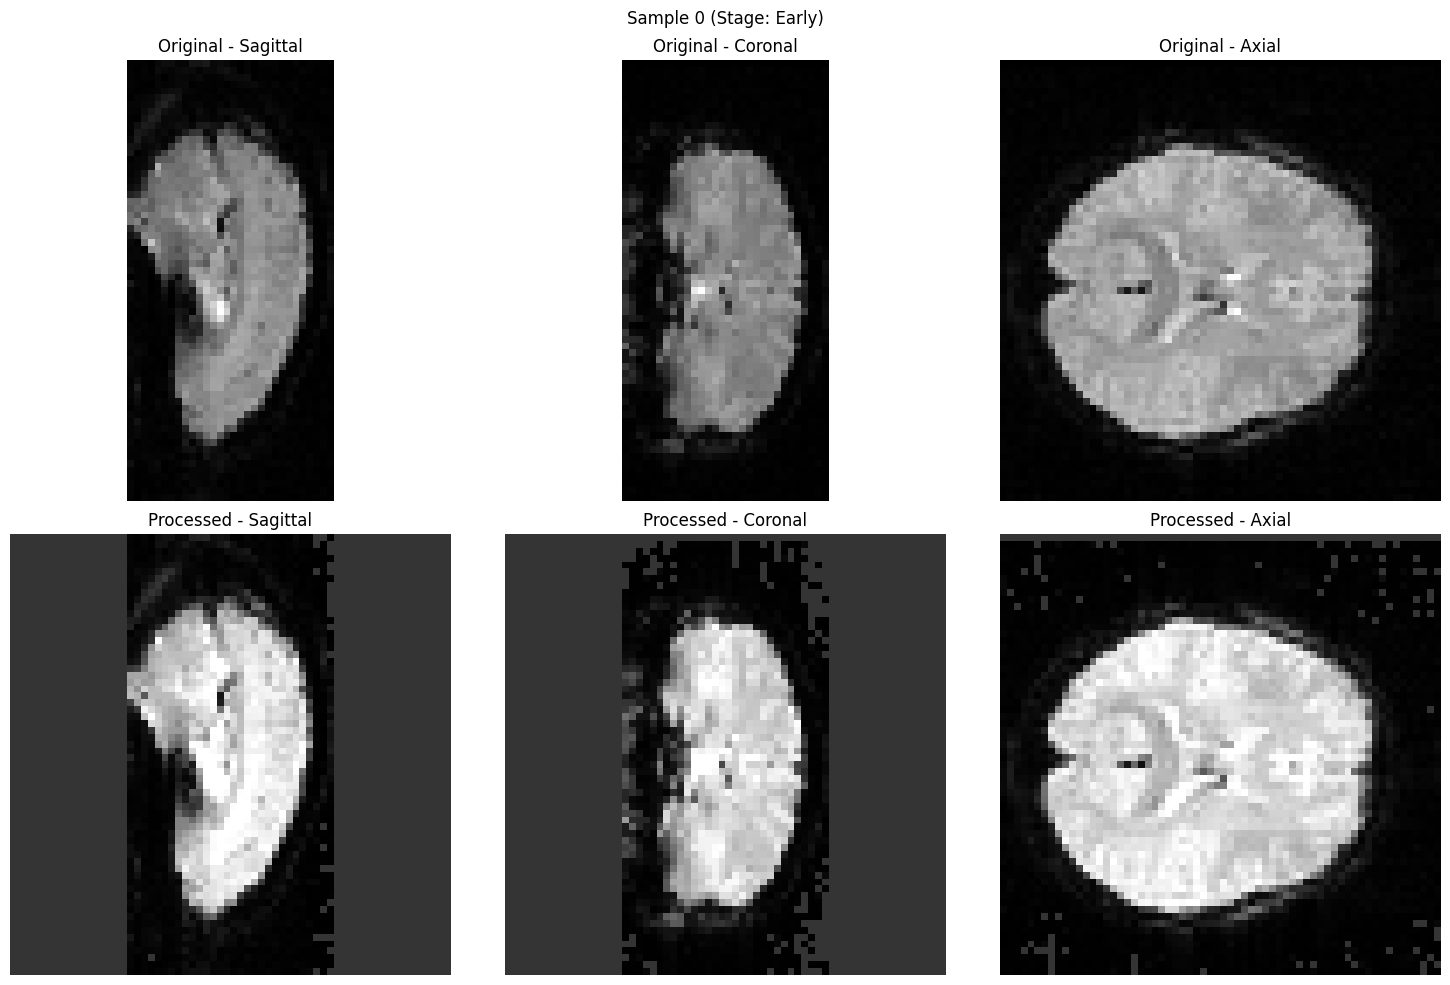


Sample Information:
File: sub-10_task-deterministicclassification_run-01_bold.nii.gz
Stage: Early
Subject: 10
Task: deterministicclassification
Dimensions: (64, 64, 30, 180)
Data Type: int16
Voxel Size: (3.125, 3.125, 5.0)
Units: ('mm', 'sec')
Run Number: 01


In [ ]:
print("\nVisualizing single sample...")
train_dataset.visualize_sample(0)

#### Initialize model

In [ ]:
model_config = {
    'img_size': 64,
    'in_channels': 1,
    'num_classes': 2
}

In [ ]:
print("\nInitializing model...")
model = ImprovedVisionTransformer3D(**model_config).to(training_config['device'])


Initializing model...


#### Print model summary

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Parameters:")
print(f"Total: {total_params:,}")
print(f"Trainable: {trainable_params:,}")


Model Parameters:
Total: 2,234,754
Trainable: 2,234,754


#### Train model


Starting training...

Training Configuration:
batch_size: 8
num_epochs: 100
learning_rate: 5e-05
weight_decay: 0.05
patience: 15
num_classes: 2
device: cuda

Epoch 1/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1 Results:
Train Loss: 4.5050, Train Acc: 54.35%
Val Loss: 2.1739, Val Acc: 40.00%
Learning Rate: 0.000025
New best model saved! Validation Accuracy: 40.00%

Epoch 2/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 2 Results:
Train Loss: 4.4463, Train Acc: 43.48%
Val Loss: 5.2525, Val Acc: 50.00%
Learning Rate: 0.000050
New best model saved! Validation Accuracy: 50.00%

Epoch 3/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 3 Results:
Train Loss: 6.5508, Train Acc: 45.65%
Val Loss: 1.9422, Val Acc: 60.00%
Learning Rate: 0.000050
New best model saved! Validation Accuracy: 60.00%

Epoch 4/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 4 Results:
Train Loss: 3.5341, Train Acc: 54.35%
Val Loss: 1.6656, Val Acc: 60.00%
Learning Rate: 0.000050

Epoch 5/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 5 Results:
Train Loss: 3.4793, Train Acc: 47.83%
Val Loss: 0.6885, Val Acc: 60.00%
Learning Rate: 0.000050

Epoch 6/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 6 Results:
Train Loss: 3.2073, Train Acc: 56.52%
Val Loss: 0.8151, Val Acc: 40.00%
Learning Rate: 0.000050

Epoch 7/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 7 Results:
Train Loss: 2.7820, Train Acc: 47.83%
Val Loss: 1.2116, Val Acc: 30.00%
Learning Rate: 0.000050

Epoch 8/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 8 Results:
Train Loss: 4.2275, Train Acc: 43.48%
Val Loss: 1.2750, Val Acc: 0.00%
Learning Rate: 0.000050

Epoch 9/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 9 Results:
Train Loss: 2.3752, Train Acc: 54.35%
Val Loss: 1.2229, Val Acc: 50.00%
Learning Rate: 0.000050

Epoch 10/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 10 Results:
Train Loss: 1.6635, Train Acc: 63.04%
Val Loss: 1.0514, Val Acc: 60.00%
Learning Rate: 0.000049

Epoch 11/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 11 Results:
Train Loss: 2.4706, Train Acc: 56.52%
Val Loss: 1.7721, Val Acc: 30.00%
Learning Rate: 0.000049

Epoch 12/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 12 Results:
Train Loss: 4.3001, Train Acc: 45.65%
Val Loss: 0.5521, Val Acc: 60.00%
Learning Rate: 0.000049

Epoch 13/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 13 Results:
Train Loss: 3.9912, Train Acc: 45.65%
Val Loss: 0.9568, Val Acc: 40.00%
Learning Rate: 0.000049

Epoch 14/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 14 Results:
Train Loss: 2.7290, Train Acc: 58.70%
Val Loss: 1.0418, Val Acc: 30.00%
Learning Rate: 0.000048

Epoch 15/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 15 Results:
Train Loss: 4.1521, Train Acc: 41.30%
Val Loss: 0.7419, Val Acc: 60.00%
Learning Rate: 0.000048

Epoch 16/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 16 Results:
Train Loss: 2.5481, Train Acc: 63.04%
Val Loss: 0.9611, Val Acc: 30.00%
Learning Rate: 0.000048

Epoch 17/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 17 Results:
Train Loss: 1.9538, Train Acc: 71.74%
Val Loss: 0.6065, Val Acc: 80.00%
Learning Rate: 0.000048
New best model saved! Validation Accuracy: 80.00%

Epoch 18/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 18 Results:
Train Loss: 1.8844, Train Acc: 63.04%
Val Loss: 0.4424, Val Acc: 90.00%
Learning Rate: 0.000047
New best model saved! Validation Accuracy: 90.00%

Epoch 19/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 19 Results:
Train Loss: 2.6361, Train Acc: 50.00%
Val Loss: 0.8104, Val Acc: 50.00%
Learning Rate: 0.000047

Epoch 20/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 20 Results:
Train Loss: 2.6096, Train Acc: 47.83%
Val Loss: 1.4849, Val Acc: 60.00%
Learning Rate: 0.000046

Epoch 21/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 21 Results:
Train Loss: 2.6461, Train Acc: 58.70%
Val Loss: 1.5373, Val Acc: 60.00%
Learning Rate: 0.000046

Epoch 22/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 22 Results:
Train Loss: 2.3072, Train Acc: 45.65%
Val Loss: 1.5120, Val Acc: 60.00%
Learning Rate: 0.000046

Epoch 23/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 23 Results:
Train Loss: 3.0923, Train Acc: 50.00%
Val Loss: 0.5153, Val Acc: 80.00%
Learning Rate: 0.000045

Epoch 24/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 24 Results:
Train Loss: 2.3765, Train Acc: 60.87%
Val Loss: 1.1453, Val Acc: 50.00%
Learning Rate: 0.000045

Epoch 25/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 25 Results:
Train Loss: 2.0995, Train Acc: 56.52%
Val Loss: 1.6198, Val Acc: 40.00%
Learning Rate: 0.000044

Epoch 26/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 26 Results:
Train Loss: 1.4253, Train Acc: 63.04%
Val Loss: 0.6966, Val Acc: 60.00%
Learning Rate: 0.000044

Epoch 27/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 27 Results:
Train Loss: 3.2786, Train Acc: 41.30%
Val Loss: 1.3690, Val Acc: 30.00%
Learning Rate: 0.000043

Epoch 28/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 28 Results:
Train Loss: 2.6722, Train Acc: 45.65%
Val Loss: 1.2915, Val Acc: 40.00%
Learning Rate: 0.000042

Epoch 29/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 29 Results:
Train Loss: 3.0519, Train Acc: 50.00%
Val Loss: 0.6451, Val Acc: 70.00%
Learning Rate: 0.000042

Epoch 30/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 30 Results:
Train Loss: 2.2801, Train Acc: 50.00%
Val Loss: 1.0497, Val Acc: 50.00%
Learning Rate: 0.000041

Epoch 31/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 31 Results:
Train Loss: 3.3762, Train Acc: 41.30%
Val Loss: 1.6918, Val Acc: 20.00%
Learning Rate: 0.000041

Epoch 32/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 32 Results:
Train Loss: 2.0220, Train Acc: 54.35%
Val Loss: 1.1512, Val Acc: 50.00%
Learning Rate: 0.000040

Epoch 33/100


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Validation:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 33 Results:
Train Loss: 3.1005, Train Acc: 39.13%
Val Loss: 0.7728, Val Acc: 40.00%
Learning Rate: 0.000039

Early stopping triggered!


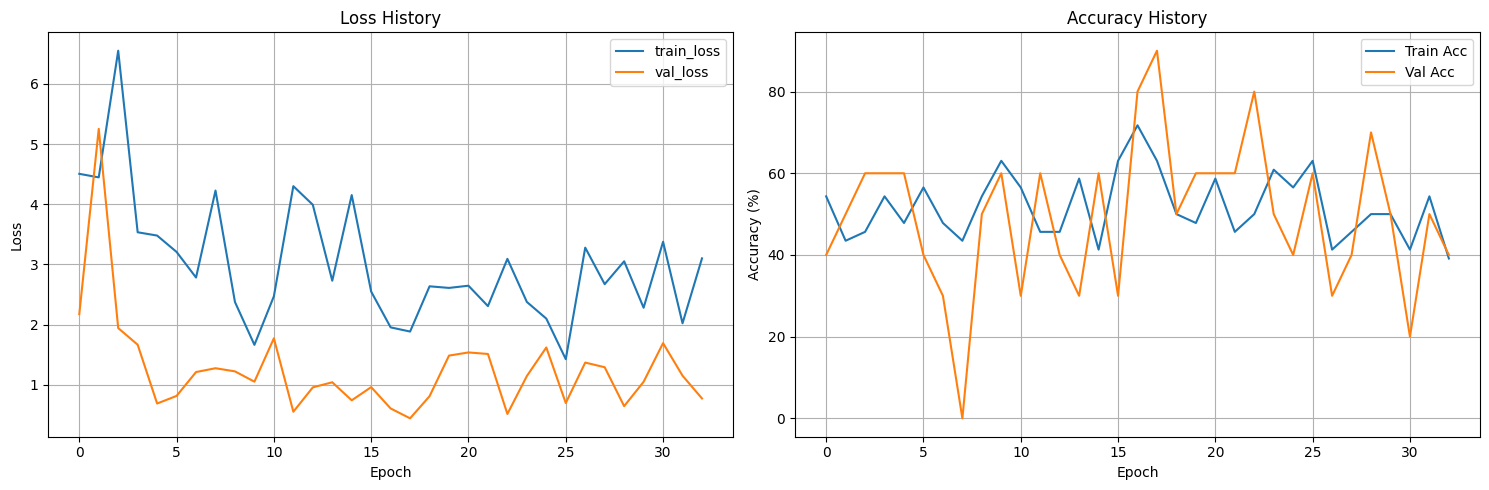


Final Metrics:
Best Validation Accuracy: 90.00%
Final Training Accuracy: 39.13%
Final Validation Accuracy: 40.00%


In [ ]:
print("\nStarting training...")
trained_model, metrics = train_model(model, train_loader, val_loader, training_config)

## Final Evaluation

In [ ]:
def evaluate_final_model(model, test_loader, device):
    """Comprehensive final model evaluation"""
    model.eval()

    # Initialize metrics
    predictions = []
    true_labels = []
    uncertainties = []
    feature_maps = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Final Evaluation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Multiple forward passes for uncertainty
            outputs_list = []
            features_list = []
            for _ in range(10):  # More MC samples for final evaluation
                outputs, features = model(inputs, return_features=True)
                outputs_list.append(F.softmax(outputs, dim=1))

            # Compute mean prediction and uncertainty
            outputs = torch.stack(outputs_list).mean(0)
            uncertainty = torch.stack(outputs_list).std(0).mean(1)

            # Store results
            _, preds = outputs.max(1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            uncertainties.extend(uncertainty.cpu().numpy())

            # Store flattened feature vectors
            if features is not None and len(features) > 0:
                batch_features = features[0].cpu().numpy()
                feature_maps.extend([feat.flatten() for feat in batch_features])

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    uncertainties = np.array(uncertainties)

    # Stack features if we have any
    if feature_maps:
        try:
            feature_maps = np.stack(feature_maps)
        except:
            print("Warning: Could not stack feature maps, returning empty array")
            feature_maps = np.array([])
    else:
        feature_maps = np.array([])

    # Print evaluation metrics
    print("\nEvaluation Results:")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels, predictions)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                              target_names=['Early Stage', 'Late Stage']))

    print("\nPrediction Statistics:")
    print(f"Total samples: {len(predictions)}")
    print(f"Correct predictions: {(predictions == true_labels).sum()}")
    print(f"Accuracy: {100 * (predictions == true_labels).mean():.2f}%")
    print(f"Mean uncertainty: {uncertainties.mean():.3f} ± {uncertainties.std():.3f}")

    return predictions, true_labels, uncertainties, feature_maps

In [ ]:
def visualize_results(predictions, true_labels, uncertainties, feature_maps):
    """Comprehensive visualization of results"""
    # 1. Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Early', 'Late'],
                yticklabels=['Early', 'Late'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # 2. Uncertainty Distribution
    plt.figure(figsize=(10, 6))
    for i in range(2):
        mask = true_labels == i
        if mask.any():
            plt.hist(uncertainties[mask], alpha=0.5,
                    label=f'{"Early" if i == 0 else "Late"} Stage',
                    bins=20)
    plt.title('Prediction Uncertainty Distribution')
    plt.xlabel('Uncertainty')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # 3. Feature Visualization
    if len(feature_maps) > 0:
        try:
            # Use t-SNE if we have enough samples
            if len(feature_maps) >= 3:
                from sklearn.manifold import TSNE
                tsne = TSNE(n_components=2, random_state=42)
                features_2d = tsne.fit_transform(feature_maps)

                plt.figure(figsize=(10, 8))
                for i in range(2):
                    mask = true_labels == i
                    plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                              label=f'{"Early" if i == 0 else "Late"} Stage',
                              alpha=0.6)
                plt.title('t-SNE Visualization of Features')
                plt.legend()
                plt.show()

            # Show correct vs incorrect predictions
            plt.figure(figsize=(10, 6))
            correct_mask = predictions == true_labels
            plt.scatter(uncertainties[correct_mask], feature_maps[correct_mask, 0],
                       label='Correct', alpha=0.6)
            plt.scatter(uncertainties[~correct_mask], feature_maps[~correct_mask, 0],
                       label='Incorrect', alpha=0.6)
            plt.xlabel('Prediction Uncertainty')
            plt.ylabel('First Feature Dimension')
            plt.title('Uncertainty vs Features')
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Warning: Could not visualize features: {str(e)}")

    # 4. Additional Analysis
    print("\nDetailed Analysis:")
    print("\nPer-class Performance:")
    for i in range(2):
        mask = true_labels == i
        class_acc = (predictions[mask] == true_labels[mask]).mean()
        class_uncertainty = uncertainties[mask].mean()
        print(f"\n{'Early' if i == 0 else 'Late'} Stage:")
        print(f"Accuracy: {100 * class_acc:.2f}%")
        print(f"Mean Uncertainty: {class_uncertainty:.3f}")

    # 5. High Uncertainty Analysis
    high_uncertainty_threshold = np.percentile(uncertainties, 75)
    high_uncertainty_mask = uncertainties > high_uncertainty_threshold
    print("\nHigh Uncertainty Predictions:")
    print(f"Threshold: {high_uncertainty_threshold:.3f}")
    print(f"Number of high uncertainty predictions: {high_uncertainty_mask.sum()}")
    print(f"Accuracy on high uncertainty predictions: {100 * (predictions[high_uncertainty_mask] == true_labels[high_uncertainty_mask]).mean():.2f}%")

In [ ]:
print("\nPerforming final evaluation...")
predictions, true_labels, uncertainties, feature_maps = evaluate_final_model(
    trained_model, test_loader, training_config['device']
)


Performing final evaluation...


Final Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]


Evaluation Results:

Confusion Matrix:
[[7 0]
 [4 1]]

Classification Report:
              precision    recall  f1-score   support

 Early Stage       0.64      1.00      0.78         7
  Late Stage       1.00      0.20      0.33         5

    accuracy                           0.67        12
   macro avg       0.82      0.60      0.56        12
weighted avg       0.79      0.67      0.59        12


Prediction Statistics:
Total samples: 12
Correct predictions: 8
Accuracy: 66.67%
Mean uncertainty: 0.000 ± 0.000



Visualizing results...


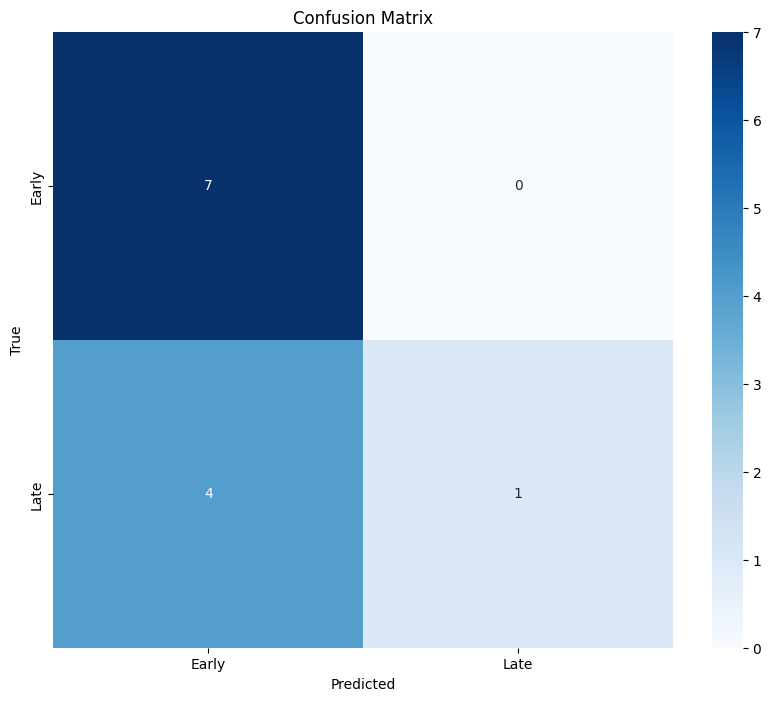

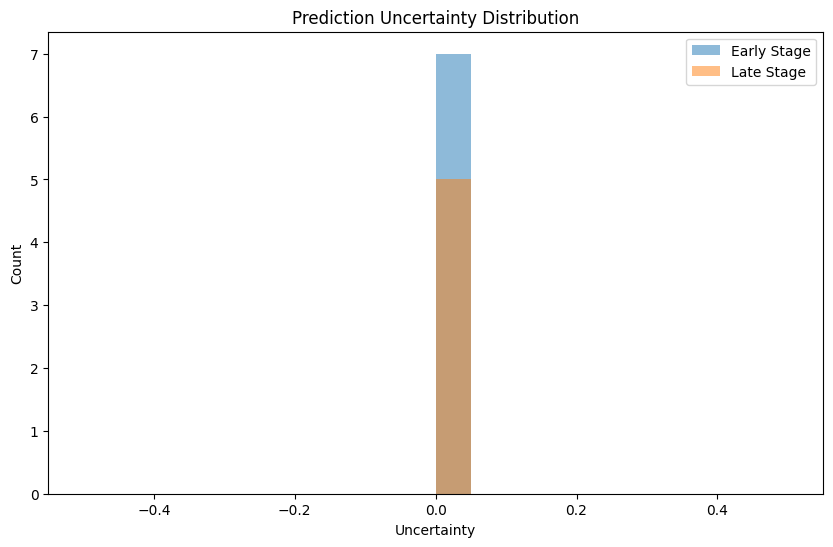


Detailed Analysis:

Per-class Performance:

Early Stage:
Accuracy: 100.00%
Mean Uncertainty: 0.000

Late Stage:
Accuracy: 20.00%
Mean Uncertainty: 0.000

High Uncertainty Predictions:
Threshold: 0.000
Number of high uncertainty predictions: 0
Accuracy on high uncertainty predictions: nan%


<ipython-input-45-bfc7e0676762>:80: RuntimeWarning: Mean of empty slice.
  print(f"Accuracy on high uncertainty predictions: {100 * (predictions[high_uncertainty_mask] == true_labels[high_uncertainty_mask]).mean():.2f}%")
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
print("\nVisualizing results...")
visualize_results(predictions, true_labels, uncertainties, feature_maps)

#### Print final metrics

In [ ]:
print("\nFinal Classification Report:")
print(classification_report(true_labels, predictions,
                          target_names=['Early Stage', 'Late Stage']))


Final Classification Report:
              precision    recall  f1-score   support

 Early Stage       0.64      1.00      0.78         7
  Late Stage       1.00      0.20      0.33         5

    accuracy                           0.67        12
   macro avg       0.82      0.60      0.56        12
weighted avg       0.79      0.67      0.59        12



#### Save final model and results

In [ ]:
final_results = {
    'predictions': predictions,
    'true_labels': true_labels,
    'uncertainties': uncertainties,
    'feature_maps': feature_maps,
    'training_history': metrics.metrics,
    'model_config': model_config,
    'training_config': training_config
}

In [ ]:
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'results': final_results
}, 'final_model_and_results.pth')